In [ ]:
##########Linking to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#to write weights
import h5py

In [ ]:
######Preprocessing the training and validation datasets
import os
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/content/gdrive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
train_2_dir = os.path.join(train_dir, '2')
train_3_dir = os.path.join(train_dir, '3')
train_4_dir = os.path.join(train_dir, '4')
train_5_dir = os.path.join(train_dir, '5')

validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')
validation_2_dir = os.path.join(validation_dir, '2')
validation_3_dir = os.path.join(validation_dir, '3')
validation_4_dir = os.path.join(validation_dir, '4')
validation_5_dir = os.path.join(validation_dir, '5')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)
train_2_fnames = os.listdir(train_2_dir)
train_3_fnames = os.listdir(train_3_dir)
train_4_fnames = os.listdir(train_4_dir)
train_5_fnames = os.listdir(train_5_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory = train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        color_mode = 'rgb', 
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        directory = validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

Found 3623 images belonging to 6 classes.
Found 609 images belonging to 6 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-31 15:42:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.253.115.128, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  86.4MB/s    in 1.0s    

2021-03-31 15:42:38 (86.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#save weights
from keras.callbacks import ModelCheckpoint
weights_file = '/content/gdrive/MyDrive/weights.hdf5'
checkpoint = ModelCheckpoint(weights_file, monitor='acc', mode='max', save_best_only=True, verbose=1)

In [ ]:
######Loading the pretrained InceptionV3 model
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
#input_shape is size of picture and 3 is RGB channel
pre_trained_model.load_weights(local_weights_file)

In [ ]:
#######Specifing the layer we will use in Inception v3
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [ ]:
####Establishing the model based on the selected layers in Inception v3
###### a stratergy of "Dropout" is also used  

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(6, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [ ]:
############Further Improving Accuracy with Fine-Tuning
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [ ]:
####Retraining and validating the model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=60,
      validation_data=validation_generator,
      validation_steps=10,
      epochs=20,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
60/60 - 358s - loss: 1.8324 - acc: 0.1683 - val_loss: 1.8050 - val_acc: 0.2200
Epoch 2/20
60/60 - 214s - loss: 1.7825 - acc: 0.1939 - val_loss: 1.7337 - val_acc: 0.2700
Epoch 3/20
60/60 - 176s - loss: 1.7492 - acc: 0.2433 - val_loss: 1.6858 - val_acc: 0.3500
Epoch 4/20
60/60 - 149s - loss: 1.7122 - acc: 0.2933 - val_loss: 1.6481 - val_acc: 0.3500
Epoch 5/20
60/60 - 135s - loss: 1.6726 - acc: 0.3255 - val_loss: 1.6486 - val_acc: 0.4100
Epoch 6/20
60/60 - 117s - loss: 1.6622 - acc: 0.3000 - val_loss: 1.6453 - val_acc: 0.3200
Epoch 7/20
60/60 - 85s - loss: 1.6095 - acc: 0.3744 - val_loss: 1.6262 - val_acc: 0.3800
Epoch 8/20
60/60 - 87s - loss: 1.5979 - acc: 0.3667 - val_loss: 1.5652 - val_acc: 0.3700
Epoch 9/20
60/60 - 73s - loss: 1.6005 - acc: 0.3517 - val_loss: 1.5272 - val_acc: 0.4800
Epoch 10/20
60/60 - 56s - loss: 1.5725 - acc: 0.3727 - val_loss: 1.5231 - val_acc: 0.4500
Epoch 11/20
60/60 - 52s - loss: 1.5626 - acc: 0.4050 - val_loss: 1.4815 - val_acc: 0.4900
Epoch 12/20
6

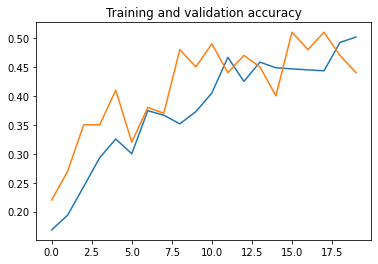

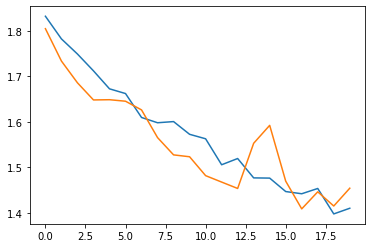

In [ ]:
#######Ploting the training and validation loss and accuracy to show it conclusively
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)

In [ ]:
######Using the retaiend model to predict mutiple new unknown iamges in a folder in Googel Drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# image folder
folder_path = '/content/gdrive/My Drive/datasets/CatVsDog/userdata'

# dimensions of images
img_width, img_height = 150, 150

# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = cv2.imread(img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_AREA)
    img = img.astype("float")/255.0 
    images.append(img)
images = np.asarray(images) 

In [ ]:
####checking the images feeded to the model
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
####Predicting

classes = model.predict(images, batch_size=10)
print(classes)

In [ ]:
#####list of all filenames
os.listdir(folder_path)

In [ ]:
train_generator.class_indices

(1, 6)
[[0.20683767 0.12152535 0.10330091 0.11536873 0.2706269  0.18234041]]


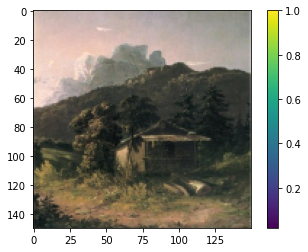

In [ ]:
#Follow these steps to make a prediction from a new file
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
#Load the image from disk
test_x = [] 
image = cv2.imread("/content/gdrive/MyDrive/Image.jpg") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (150,150), interpolation = cv2.INTER_AREA) 
test_x.append(image)

#Then pre-process the test image:
test_x = np.asarray(test_x) 
test_processed_x = test_x.astype("float")/255.0
#Then you can predict from your model like this:

test_predictions = model.predict(test_processed_x, batch_size=1) 
print(test_predictions.shape) 
print(test_predictions)
plt.figure()
plt.imshow(test_processed_x[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#terminate the kernel and free memory resources
import os, signal
os.kill(os.getpid(), signal.SIGKILL)